Part 1:

1. Read market_data.csv (columns: timestamp, symbol, price) using the built-in csv module.

2. Parse each row into a MarketDataPoint and collect them in a list.

3. Analyze space complexity of storing the full dataset in memory.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

from datetime import datetime
from models import MarketDataPoint

market_data = []

with open('data/market_data_1000.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:

        # timestamp = datetime.fromisoformat(row['timestamp'])
        timestamp = datetime.fromisoformat(row['timestamp'])

        symbol = row['symbol']
        price = float(row['price'])

        market_data.append(MarketDataPoint(timestamp, symbol, price))

# sample:
market_data[0:5]

[MarketDataPoint(timestamp=datetime.datetime(2025, 10, 8, 17, 40, 30, 778698), symbol='AAPL', price=143.17, daily_volume=None),
 MarketDataPoint(timestamp=datetime.datetime(2025, 10, 8, 17, 40, 30, 791266), symbol='AAPL', price=141.93, daily_volume=None),
 MarketDataPoint(timestamp=datetime.datetime(2025, 10, 8, 17, 40, 30, 803873), symbol='AAPL', price=141.63, daily_volume=None),
 MarketDataPoint(timestamp=datetime.datetime(2025, 10, 8, 17, 40, 30, 816432), symbol='AAPL', price=141.83, daily_volume=None),
 MarketDataPoint(timestamp=datetime.datetime(2025, 10, 8, 17, 40, 30, 828978), symbol='AAPL', price=141.54, daily_volume=None)]

In [2]:
# or in actual engine

from engine import ExecutionEngine

x = ExecutionEngine()
x.load_data('data/market_data_1000.csv')

x._market_data[0:5]

[MarketDataPoint(timestamp=datetime.datetime(2025, 10, 8, 17, 40, 30, 778698), symbol='AAPL', price=143.17, daily_volume=None),
 MarketDataPoint(timestamp=datetime.datetime(2025, 10, 8, 17, 40, 30, 791266), symbol='AAPL', price=141.93, daily_volume=None),
 MarketDataPoint(timestamp=datetime.datetime(2025, 10, 8, 17, 40, 30, 803873), symbol='AAPL', price=141.63, daily_volume=None),
 MarketDataPoint(timestamp=datetime.datetime(2025, 10, 8, 17, 40, 30, 816432), symbol='AAPL', price=141.83, daily_volume=None),
 MarketDataPoint(timestamp=datetime.datetime(2025, 10, 8, 17, 40, 30, 828978), symbol='AAPL', price=141.54, daily_volume=None)]

# Timing

In [3]:
import subprocess
import timeit
import cProfile
from memory_profiler import memory_usage

In [4]:

def run_engine():
    subprocess.run(["python3", "engine.py", "data/market_data_1000.csv", "NaiveMovingAverageStrategy"])

# Measure execution time using timeit
execution_time = timeit.timeit(run_engine, number=1)
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 1.48 seconds


In [5]:

def run_engine():
    subprocess.run(["python3", "engine.py", "data/market_data_1000.csv", "WindowedMovingAverageStrategy"])

# Measure execution time using timeit
execution_time = timeit.timeit(run_engine, number=1)
print(f"Execution time: {execution_time:.2f} seconds")


Execution time: 1.30 seconds


In [6]:
import timeit
import cProfile
import pstats
from memory_profiler import memory_usage
import sys
import os

# Add the current directory to Python path so we can import modules
sys.path.append(os.getcwd())

from engine import ExecutionEngine
from strategies.NaiveMovingAverageStrategy import NaiveMovingAverageStrategy
from strategies.WindowedMovingAverageStrategy import WindowedMovingAverageStrategy

def measure_strategy_performance(data_path, strategy_class, symbol='AAPL'):
    """Measure performance of a specific strategy on given data."""
    
    def run_strategy():
        engine = ExecutionEngine(failure_rate=0.0, initial_capital=1_000_000.0)
        strategy = strategy_class(symbol=symbol, capital=0)
        engine.run([strategy], data_path)
        return engine
    
    # Measure execution time
    execution_time = timeit.timeit(run_strategy, number=1)
    
    # Measure peak memory usage (not the difference!)
    mem_usage = memory_usage(run_strategy, max_iterations=1, interval=0.1)
    peak_memory = max(mem_usage)  # This is the actual peak memory usage
    
    # Profile execution
    profiler = cProfile.Profile()
    profiler.enable()
    engine = run_strategy()
    profiler.disable()
    
    # Get profiling stats
    stats = pstats.Stats(profiler)
    
    return {
        'execution_time': execution_time,
        'peak_memory_mb': peak_memory,
        'profiler_stats': stats,
        'data_points': len(engine._market_data)
    }

# Test with different data sizes
data_files = [
    'data/market_data_1000.csv',
    'data/market_data_10000.csv', 
    'data/market_data_100000.csv'
]

results_Naive = {}
results_Windowed = {}

for data_file in data_files:
    print(f"\n=== Testing {data_file} ===")
    
    # Measure NaiveMovingAverageStrategy
    result = measure_strategy_performance(data_file, NaiveMovingAverageStrategy)
    
    print(f"Execution time: {result['execution_time']:.2f} seconds")
    print(f"Peak memory usage: {result['peak_memory_mb']:.2f} MiB")
    print(f"Data points processed: {result['data_points']}")
    
    # Show top 10 functions by cumulative time
    print("\nTop 10 functions by cumulative time:")
    result['profiler_stats'].sort_stats('cumulative').print_stats(4)
    
    results_Naive[data_file] = result

for data_file in data_files:
    print(f"\n=== Testing {data_file} ===")
    
    # Measure NaiveMovingAverageStrategy
    result = measure_strategy_performance(data_file, WindowedMovingAverageStrategy)
    
    print(f"Execution time: {result['execution_time']:.2f} seconds")
    print(f"Peak memory usage: {result['peak_memory_mb']:.2f} MiB")
    print(f"Data points processed: {result['data_points']}")
    
    # Show top 10 functions by cumulative time
    print("\nTop 10 functions by cumulative time:")
    result['profiler_stats'].sort_stats('cumulative').print_stats(4)
    
    results_Windowed[data_file] = result


=== Testing data/market_data_1000.csv ===
Execution time: 0.20 seconds
Peak memory usage: 126.43 MiB
Data points processed: 1000

Top 10 functions by cumulative time:
         411079 function calls (355845 primitive calls) in 0.789 seconds

   Ordered by: cumulative time
   List reduced from 150 to 4 due to restriction <4>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.790    0.790 /var/folders/ty/5gy6m3k52ps97ms9_x3glvnh0000gn/T/ipykernel_12550/2492840911.py:18(run_strategy)
        1    0.039    0.039    0.790    0.790 /Users/olegglotov/Documents/CHICAGO code/Sept + Winter/FINM - Computing for Finance/Assign/FINM32500-A3/engine.py:123(run)
     2989    0.021    0.000    0.512    0.000 /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/logging/__init__.py:1510(info)
     3003    0.016    0.000    0.491    0.000 /Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/logging/__init__.py:1641(_log)



=

In [7]:
results_Naive

{'data/market_data_1000.csv': {'execution_time': 0.2031331390608102,
  'peak_memory_mb': 126.4296875,
  'profiler_stats': <pstats.Stats at 0x10d8dcad0>,
  'data_points': 1000},
 'data/market_data_10000.csv': {'execution_time': 4.5200891819549724,
  'peak_memory_mb': 131.37890625,
  'profiler_stats': <pstats.Stats at 0x10d9511d0>,
  'data_points': 10000},
 'data/market_data_100000.csv': {'execution_time': 169.80838651605882,
  'peak_memory_mb': 203.234375,
  'profiler_stats': <pstats.Stats at 0x10d951090>,
  'data_points': 100000}}

In [8]:
results_Windowed

{'data/market_data_1000.csv': {'execution_time': 0.0608781959163025,
  'peak_memory_mb': 150.125,
  'profiler_stats': <pstats.Stats at 0x10d9bc8a0>,
  'data_points': 1000},
 'data/market_data_10000.csv': {'execution_time': 0.4661764890188351,
  'peak_memory_mb': 149.41796875,
  'profiler_stats': <pstats.Stats at 0x10d9bd5b0>,
  'data_points': 10000},
 'data/market_data_100000.csv': {'execution_time': 5.247696791077033,
  'peak_memory_mb': 151.00390625,
  'profiler_stats': <pstats.Stats at 0x10d7032f0>,
  'data_points': 100000}}

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Plotting

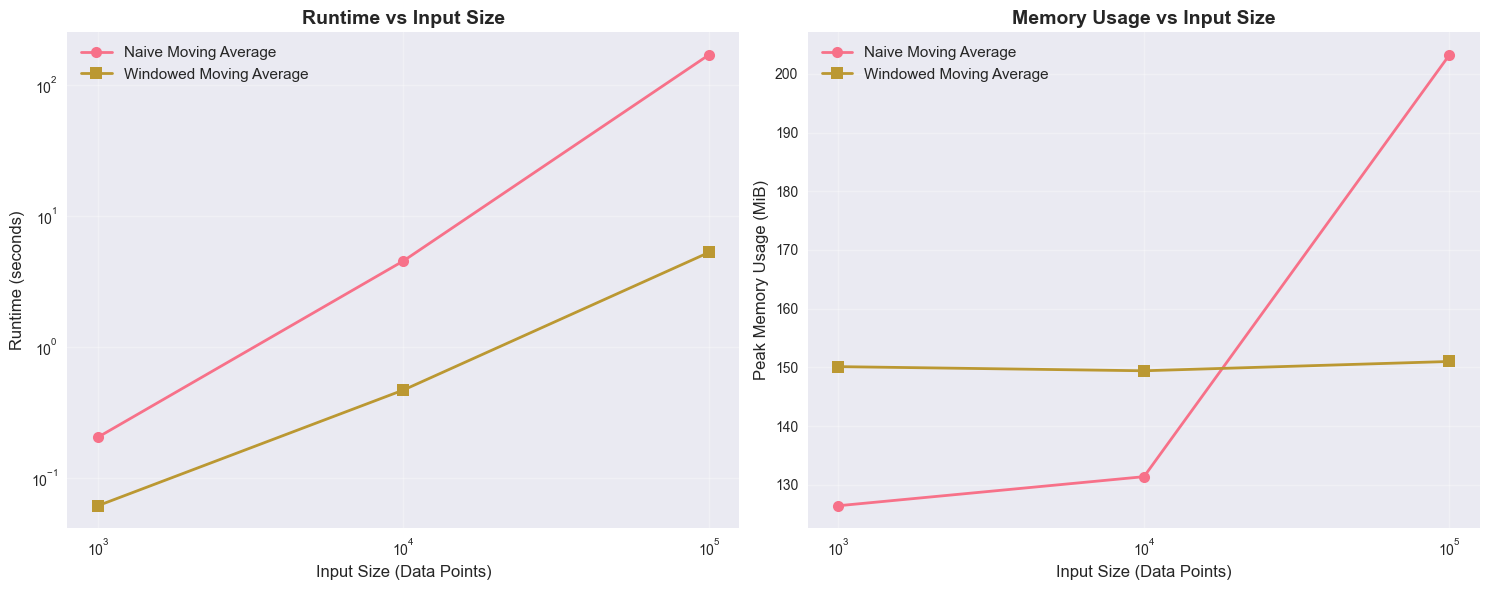


Performance Summary:
 Data Size  Naive Runtime (s)  Windowed Runtime (s)  Naive Memory (MiB)  Windowed Memory (MiB)
      1000           0.203133              0.060878          126.429688             150.125000
     10000           4.520089              0.466176          131.378906             149.417969
    100000         169.808387              5.247697          203.234375             151.003906

Performance Analysis:
Runtime ratio (Naive/Windowed) at 100K points: 32.36x
Memory ratio (Naive/Windowed) at 100K points: 1.35x


In [10]:
# Extract data from your performance results
data_sizes = [1000, 10000, 100000]

naive_runtime = list(results_Naive.values())
windowed_runtime = list(results_Windowed.values())

naive_runtime = [result['execution_time'] for result in results_Naive.values()]
windowed_runtime = [result['execution_time'] for result in results_Windowed.values()]

naive_memory = [result['peak_memory_mb'] for result in results_Naive.values()]
windowed_memory = [result['peak_memory_mb'] for result in results_Windowed.values()]

# Create DataFrames for easier plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Runtime vs Input Size
ax1.plot(data_sizes, naive_runtime, 'o-', linewidth=2, markersize=8, label='Naive Moving Average')
ax1.plot(data_sizes, windowed_runtime, 's-', linewidth=2, markersize=8, label='Windowed Moving Average')
ax1.set_xlabel('Input Size (Data Points)', fontsize=12)
ax1.set_ylabel('Runtime (seconds)', fontsize=12)
ax1.set_title('Runtime vs Input Size', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plot 2: Memory Usage vs Input Size
ax2.plot(data_sizes, naive_memory, 'o-', linewidth=2, markersize=8, label='Naive Moving Average')
ax2.plot(data_sizes, windowed_memory, 's-', linewidth=2, markersize=8, label='Windowed Moving Average')
ax2.set_xlabel('Input Size (Data Points)', fontsize=12)
ax2.set_ylabel('Peak Memory Usage (MiB)', fontsize=12)
ax2.set_title('Memory Usage vs Input Size', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Adjust layout and show
plt.tight_layout()
plt.show()

# Create a summary table
summary_data = {
    'Data Size': data_sizes,
    'Naive Runtime (s)': naive_runtime,
    'Windowed Runtime (s)': windowed_runtime,
    'Naive Memory (MiB)': naive_memory,
    'Windowed Memory (MiB)': windowed_memory
}

summary_df = pd.DataFrame(summary_data)
print("\nPerformance Summary:")
print(summary_df.to_string(index=False))

# Calculate performance ratios
print(f"\nPerformance Analysis:")
print(f"Runtime ratio (Naive/Windowed) at 100K points: {naive_runtime[2]/windowed_runtime[2]:.2f}x")
print(f"Memory ratio (Naive/Windowed) at 100K points: {naive_memory[2]/windowed_memory[2]:.2f}x")

# Complexity Report

### Naive Moving Average Strategy

  - `Time complexity:O(n^2)`
  - `Space complexity: O(n)`

The time complexity of the naive moving average strategy is O(n), where n is the number of data points. But since the engine is running on a single thread, the time complexity is O(n^2), where n is the number of data points.

Space complexity is O(n), since the strategy needs recompute the moving average for each data point.

### Windowed Moving Average Strategy

  - `Time complexity: O(n)`
  - `Space complexity: O(k)`

The time complexity of the windowed moving average strategy is O(1), since the window is computed in O(1). With the engine runtime this expands to O(n), where n is the number of data points.

Space complexity is O(k), where k = window_size.


## Full-History vs. Windowed Approaches

### Full-History Approach (Naive Strategy)
- **Memory Growth**: O(n) - Linear growth with input size
- **Storage**: Keeps ALL historical prices forever
- **Memory Formula**: `memory ≈ n × sizeof(float) + overhead`
- **Behavior**: Memory usage grows continuously and never decreases

### Windowed Approach 
- **Memory Growth**: O(k) - Constant regardless of input size  
- **Storage**: Only keeps last `k` prices (window_size = 40)
- **Memory Formula**: `memory ≈ k × sizeof(float) + overhead` 
- **Behavior**: Memory plateaus after filling window, then stays constant

### Key Differences
1. **Scalability**: Naive memory grows unbounded; windowed plateaus quickly
2. **Predictability**: Windowed memory usage is predictable and bounded
3. **Production Impact**: In real trading systems processing millions of ticks, memory difference would be dramatic
